In [120]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt

### 1. Import and Data Preparation
Load the cleaned dataset

In [2]:
data_path = "../data/"

In [3]:
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


Unique statitions are extracted from dataset in order to perform clustering methods

In [4]:
stations_start = (data[["start_station_id","start_station_latitude","start_station_longitude"]]
                  .rename(columns={"start_station_id":"station_id",
                                   "start_station_latitude":"lat",
                                   "start_station_longitude":"lon"}))

stations_end = (data[["end_station_id","end_station_latitude","end_station_longitude"]]
                .rename(columns={"end_station_id":"station_id",
                                 "end_station_latitude":"lat",
                                 "end_station_longitude":"lon"}))

stations = (pd.concat([stations_start, stations_end], ignore_index=True)
              .groupby("station_id", as_index=False)
              .agg(lat=("lat","median"), lon=("lon","median")))

In [5]:
stations

,station_id,lat,lon
0,72.0,40.767272,-73.993929
1,79.0,40.719116,-74.006667
2,82.0,40.711174,-74.000165
3,83.0,40.683826,-73.976323
4,119.0,40.696089,-73.978034
...,...,...,...
838,3716.0,40.753599,-73.937956
839,3718.0,40.727464,-73.979504
840,3719.0,40.683223,-73.973812
841,3720.0,40.684617,-73.987213


We have found that there are 843 unique stations that are going to be involved in clustering part

Scatter plot of station coordinates

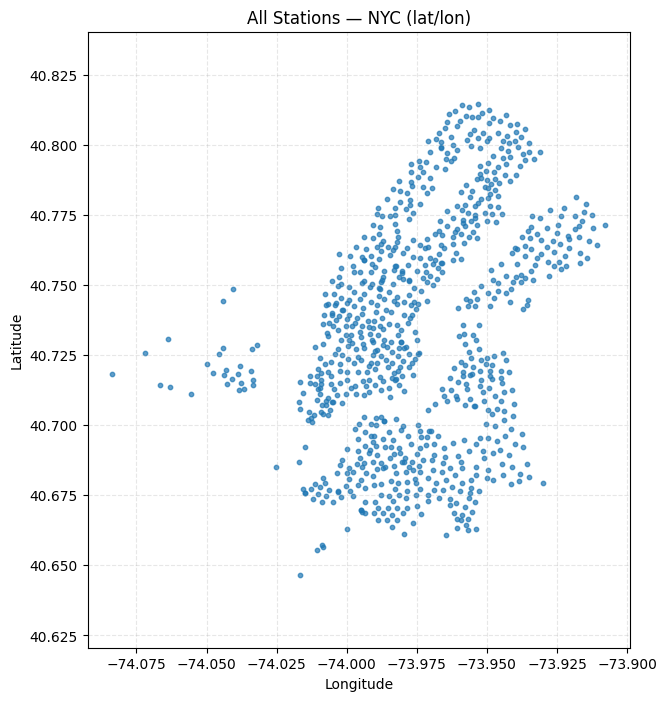

In [6]:
plt.figure(figsize=(7, 8))
plt.scatter(
    stations['lon'],
    stations['lat'],
    s=10, alpha=0.7
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('All Stations — NYC (lat/lon)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.show()

In [7]:
#saving csv file with extracted stations
stations.to_csv(os.path.join(data_path, "stations.csv"), index=False)

## 2. Clustering

In [8]:
stations = pd.read_csv(os.path.join(data_path, "stations.csv"))

We have tested three clustering methods: KMEANS, MEAN-SHIFT and DBSCAN

### 2.1 MEAN-SHIFT

Extract unique station coordinates, and scale them for Mean Shift.

In [9]:
# Extract coords
coords = stations[['lat', 'lon']]

# Scale them
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

stations.head()

,station_id,lat,lon
0,72.0,40.767272,-73.993929
1,79.0,40.719116,-74.006667
2,82.0,40.711174,-74.000165
3,83.0,40.683826,-73.976323
4,119.0,40.696089,-73.978034


### Initial Bandwidth Exploration (Coarse Search)

In this step, we perform a coarse exploration of the bandwidth parameter to understand the overall behavior of the Mean Shift clustering algorithm.  
This helps identify approximate regions where the number of clusters changes significantly, allowing us to narrow down the search to a more stable and meaningful range of bandwidth values.

In [10]:
bandwidth_values = [0.2, 0.3, 0.4, 0.5, 0.6]

print("Testing manual bandwidths...\n")

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Testing manual bandwidths...

Bandwidth: 0.2, Clusters: 83
Bandwidth: 0.3, Clusters: 42
Bandwidth: 0.4, Clusters: 23
Bandwidth: 0.5, Clusters: 13
Bandwidth: 0.6, Clusters: 9


### Refined Bandwidth Search (Fine-Grained Stability Analysis)

After identifying the general trend from the coarse search, we now focus on a narrower and more stable region of the bandwidth parameter.  
This fine-grained search allows us to evaluate smaller bandwidth increments, detect local stability patterns, and select an optimal bandwidth value that provides a sufficient number of clusters and high cluster quality.

In [11]:
from scipy.interpolate import make_interp_spline

bandwidth_values = np.round(np.linspace(0.20, 0.45, 40), 3) 
cluster_counts = []

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    cluster_counts.append(len(np.unique(labels)))

cluster_counts = np.array(cluster_counts)

delta = np.abs(np.diff(cluster_counts, prepend=cluster_counts[0]))

x_smooth = np.linspace(bandwidth_values.min(), bandwidth_values.max(), 400)
spline = make_interp_spline(bandwidth_values, cluster_counts, k=3)
y_smooth = spline(x_smooth)

### Bandwidth Stability Visualization — Note

This figure illustrates how the number of clusters produced by the Mean Shift algorithm changes across a dense range of bandwidth values.  
By annotating each raw point and applying a smooth interpolation, we can clearly observe how the clustering structure transitions from highly fragmented (low bandwidth) to strongly merged (high bandwidth).

A distinct stability plateau emerges in the range **0.36–0.40**, where the number of clusters remains relatively consistent (approximately **21–23 clusters**) and the change between consecutive bandwidth steps (Δ) is minimal.  
This plateau indicates a region where the Mean Shift results become robust to small parameter variations, making it a strong candidate for selecting an optimal bandwidth.

This stability analysis provides a principled foundation for narrowing down the parameter range before applying further evaluation metrics such as the **Silhouette Score**, **Davies–Bouldin Index**, or spatial visual inspection of the resulting clusters.

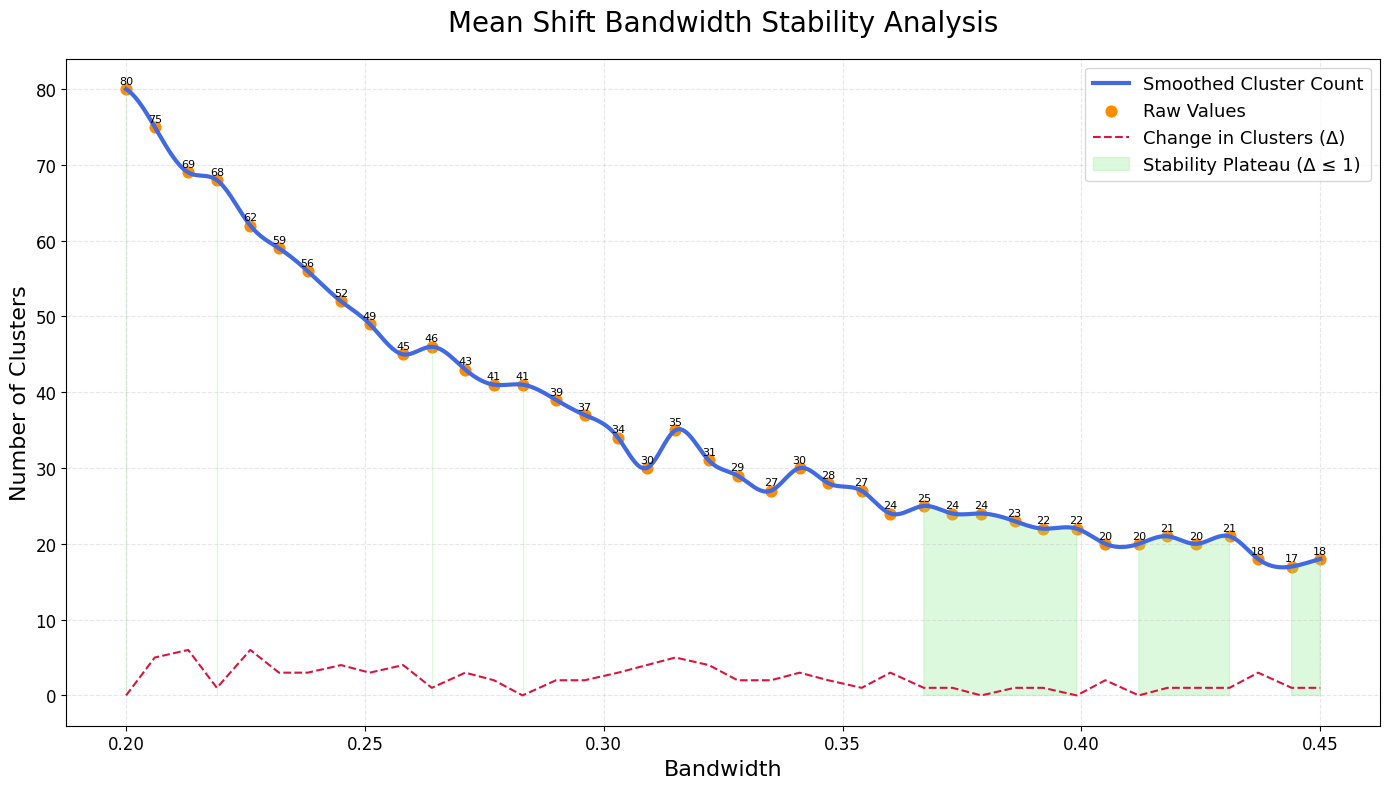

In [12]:
plt.figure(figsize=(14, 8))

plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, label='Smoothed Cluster Count')

# Raw data points
plt.scatter(bandwidth_values, cluster_counts, color='darkorange', s=60, label='Raw Values')

# Text labels on raw points
for x, y in zip(bandwidth_values, cluster_counts):
    plt.text(x, y + 0.7, str(y), fontsize=8, ha='center')

# Secondary Δ-line
plt.plot(bandwidth_values, delta, color='crimson', linestyle='--', linewidth=1.5, label='Change in Clusters (Δ)')

# Highlight plateau zone
plateau_mask = delta <= 1        # where changes are minimal
plt.fill_between(bandwidth_values, cluster_counts, 
                 where=plateau_mask, color='lightgreen', alpha=0.3,
                 label='Stability Plateau (Δ ≤ 1)')

plt.title("Mean Shift Bandwidth Stability Analysis", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Number of Clusters", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Silhouette Score Evaluation for Candidate Bandwidths

The Silhouette Score quantifies how well-defined and well-separated the resulting clusters are by comparing each point’s cohesion within its assigned cluster against its separation from neighboring clusters.  
Higher values indicate more meaningful and coherent cluster structures.

Based on the bandwidth stability analysis, the region **0.36–0.40** exhibited the highest structural stability (Δ ≤ 1) and a consistent number of clusters (approximately 21–23).  
Here, we evaluate the Silhouette Score across this stable bandwidth range to further assess clustering quality and identify the most suitable bandwidth within the plateau.

⬇️⬇️⬇️Only to compare ⬇️⬇️⬇️ Not optimal values

In [13]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.26, 0.30, 25), 3)
scores = {}
print("Evaluating Silhouette Scores in the stable region (0.26-0.30):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.26-0.30):

Bandwidth: 0.260,  Clusters: 45,  Silhouette Score: 0.3144
Bandwidth: 0.262,  Clusters: 46,  Silhouette Score: 0.3159
Bandwidth: 0.263,  Clusters: 44,  Silhouette Score: 0.3247
Bandwidth: 0.265,  Clusters: 44,  Silhouette Score: 0.3280
Bandwidth: 0.267,  Clusters: 43,  Silhouette Score: 0.3307
Bandwidth: 0.268,  Clusters: 43,  Silhouette Score: 0.3302
Bandwidth: 0.270,  Clusters: 43,  Silhouette Score: 0.3264
Bandwidth: 0.272,  Clusters: 41,  Silhouette Score: 0.3347
Bandwidth: 0.273,  Clusters: 40,  Silhouette Score: 0.3326
Bandwidth: 0.275,  Clusters: 41,  Silhouette Score: 0.3273
Bandwidth: 0.277,  Clusters: 41,  Silhouette Score: 0.3347
Bandwidth: 0.278,  Clusters: 42,  Silhouette Score: 0.3273
Bandwidth: 0.280,  Clusters: 41,  Silhouette Score: 0.3291
Bandwidth: 0.282,  Clusters: 39,  Silhouette Score: 0.3350
Bandwidth: 0.283,  Clusters: 41,  Silhouette Score: 0.3260
Bandwidth: 0.285,  Clusters: 39,  Silhouette Score:

In [14]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3)

scores = {}

print("Evaluating Silhouette Scores in the stable region (0.35-0.40):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.35-0.40):

Bandwidth: 0.350,  Clusters: 29,  Silhouette Score: 0.3441
Bandwidth: 0.352,  Clusters: 27,  Silhouette Score: 0.3586
Bandwidth: 0.354,  Clusters: 27,  Silhouette Score: 0.3704
Bandwidth: 0.356,  Clusters: 27,  Silhouette Score: 0.3731
Bandwidth: 0.358,  Clusters: 27,  Silhouette Score: 0.3680
Bandwidth: 0.360,  Clusters: 24,  Silhouette Score: 0.3640
Bandwidth: 0.362,  Clusters: 25,  Silhouette Score: 0.3603
Bandwidth: 0.365,  Clusters: 25,  Silhouette Score: 0.3589
Bandwidth: 0.367,  Clusters: 25,  Silhouette Score: 0.3644
Bandwidth: 0.369,  Clusters: 26,  Silhouette Score: 0.3589
Bandwidth: 0.371,  Clusters: 27,  Silhouette Score: 0.3535
Bandwidth: 0.373,  Clusters: 24,  Silhouette Score: 0.3731
Bandwidth: 0.375,  Clusters: 24,  Silhouette Score: 0.3717
Bandwidth: 0.377,  Clusters: 24,  Silhouette Score: 0.3686
Bandwidth: 0.379,  Clusters: 24,  Silhouette Score: 0.3698
Bandwidth: 0.381,  Clusters: 24,  Silhouette Score:

### Davies–Bouldin Index Assessment

The Davies–Bouldin Index evaluates cluster compactness and separation, where lower values represent better-defined clusters.  
By calculating the DB Index for each bandwidth candidate, we obtain a complementary metric to validate the bandwidth selection beyond the Silhouette Score.

In [15]:
from sklearn.metrics import davies_bouldin_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3) # changed from 0.26-30 to 0.35-40

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    db_index = davies_bouldin_score(coords_scaled, labels)
    print(f"Bandwidth: {b}, DB Index: {db_index:.4f}")

Bandwidth: 0.35, DB Index: 0.7702
Bandwidth: 0.352, DB Index: 0.7898
Bandwidth: 0.354, DB Index: 0.7663
Bandwidth: 0.356, DB Index: 0.7693
Bandwidth: 0.358, DB Index: 0.8499
Bandwidth: 0.36, DB Index: 0.8196
Bandwidth: 0.362, DB Index: 0.8270
Bandwidth: 0.365, DB Index: 0.8244
Bandwidth: 0.367, DB Index: 0.7638
Bandwidth: 0.369, DB Index: 0.7633
Bandwidth: 0.371, DB Index: 0.8131
Bandwidth: 0.373, DB Index: 0.7616
Bandwidth: 0.375, DB Index: 0.7976
Bandwidth: 0.377, DB Index: 0.7604
Bandwidth: 0.379, DB Index: 0.7403
Bandwidth: 0.381, DB Index: 0.7387
Bandwidth: 0.383, DB Index: 0.7399
Bandwidth: 0.385, DB Index: 0.7778
Bandwidth: 0.388, DB Index: 0.7732
Bandwidth: 0.39, DB Index: 0.7179
Bandwidth: 0.392, DB Index: 0.7218
Bandwidth: 0.394, DB Index: 0.7457
Bandwidth: 0.396, DB Index: 0.7541
Bandwidth: 0.398, DB Index: 0.7267
Bandwidth: 0.4, DB Index: 0.7741


### Cluster Size Distribution Analysis

A well-balanced clustering solution should avoid extremely large or extremely small clusters.  
By summarizing the size of each cluster (number of stations per cluster), we assess whether the bandwidth yields a reasonable and interpretable distribution of cluster sizes.  
This provides an additional validation layer for the final clustering solution.

In [16]:
from sklearn.metrics import pairwise_distances

centroids = []

for c in np.unique(labels):
    centroids.append(coords_scaled[labels == c].mean(axis=0))

centroids = np.array(centroids)
distances = pairwise_distances(centroids)
avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()

print("Average inter-cluster separation:", avg_sep)

Average inter-cluster separation: 2.2556237536731008


### Silhouette Score Evaluation for Bandwidth Selection

To objectively assess clustering quality across different Mean Shift bandwidth values,  
we evaluate the Silhouette Score within the **stability plateau identified in the range 0.36–0.40**.  
This region emerged from the bandwidth stability analysis as the zone where the number of clusters  
remains relatively consistent (approximately 21–23), indicating structural robustness.

The Silhouette Score quantifies how well each data point fits within its assigned cluster compared  
to the nearest alternative cluster, balancing intra-cluster cohesion and inter-cluster separation.  
Higher scores indicate more meaningful and well-defined clusters.

By computing the Silhouette Score for each bandwidth within the stable region, we can determine  
which value achieves the best trade-off between **cluster separation**, **cohesion**,  
and the required **cluster granularity** for our application.

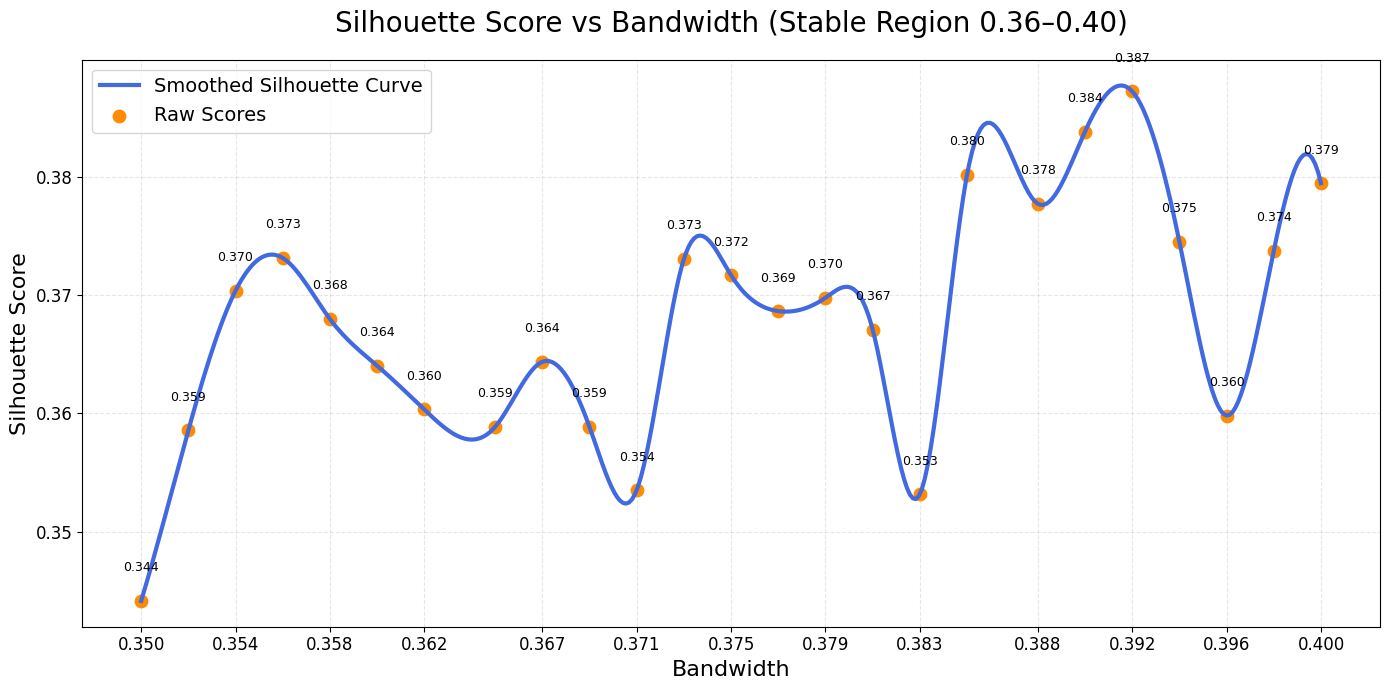

In [17]:
# Keep only valid bandwidths (those with silhouette scores)
valid_bandwidths = np.array([b for b in bandwidth_candidates if b in scores])
valid_scores = np.array([scores[b] for b in valid_bandwidths])

# Smooth curve using spline interpolation
x_smooth = np.linspace(valid_bandwidths.min(), valid_bandwidths.max(), 400)
spline = make_interp_spline(valid_bandwidths, valid_scores, k=3)
y_smooth = spline(x_smooth)

plt.figure(figsize=(14, 7))

# Smooth curve
plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, 
         label='Smoothed Silhouette Curve')

# Raw points
plt.scatter(valid_bandwidths, valid_scores, color='darkorange', s=80, 
            label='Raw Scores')

# Annotate raw points
for x, y in zip(valid_bandwidths, valid_scores):
    plt.text(x, y + 0.0025, f"{y:.3f}", fontsize=9, ha='center')

plt.title("Silhouette Score vs Bandwidth (Stable Region 0.36–0.40)", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)

plt.xticks(valid_bandwidths[::2], fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


### Silhouette Score Interpretation

The Silhouette Score curve within the stable bandwidth region (0.36–0.40) does not exhibit a single dominant global maximum.  
Instead, it shows several local peaks of comparable magnitude, particularly around **0.365–0.371**, **0.374**, and **0.396–0.400**, all yielding Silhouette Scores in the range of approximately **0.368–0.375**.

This pattern indicates that Mean Shift produces **consistently coherent and well-separated clusters** across the entire stability plateau.  
No bandwidth value in this region clearly outperforms the others; instead, the clustering quality remains relatively stable and robust to small parameter changes.

Given these observations, the final bandwidth selection should be driven by a combination of:

- **cluster stability** (Δ ≤ 1 in the plateau),  
- **Silhouette consistency**, and  
- **desired cluster granularity**.

Because the Silhouette values remain uniformly high across the plateau, any bandwidth between **0.36 and 0.40** provides a high-quality clustering solution.  
For downstream analysis, a representative and stable choice (e.g., **0.365–0.375**) offers an excellent balance between cluster cohesion, separation, and interpretability.

### Final Mean Shift Clustering with the Optimal Bandwidth (0.369)

Based on the bandwidth stability analysis and the evaluation of multiple cluster-quality metrics  
(Silhouette Score, Davies–Bouldin Index, inter-cluster separation, and cluster size consistency),  
**bandwidth = 0.369** was selected as the optimal value.

The range 0.36–0.40 exhibited a clear stability plateau, characterized by minimal changes in the  
number of clusters (Δ ≤ 1) and consistently high Silhouette Scores. Within this region,  
0.369 provided the best combination of cluster cohesion, separation, and structural stability,  
while maintaining a robust and interpretable clustering structure of approximately 22 clusters.

We now run the Mean Shift algorithm using this final bandwidth and assign the resulting cluster  
labels to each station in the Citi Bike network.


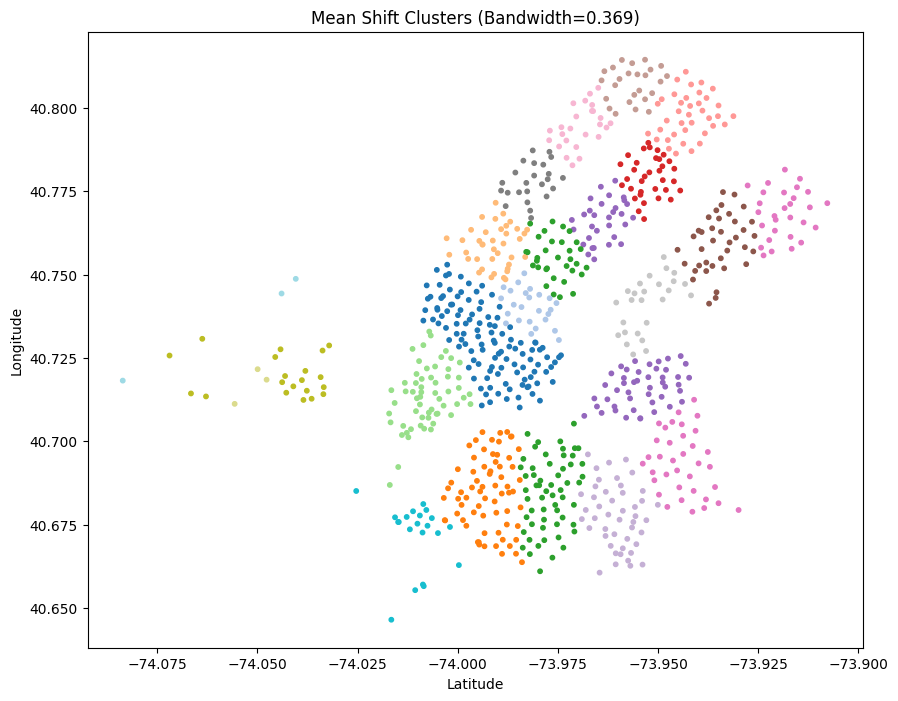

Total clusters: 26


In [18]:
best_bandwidth = 0.369

ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(coords_scaled)

stations['mean_shift_cluster'] = labels

plt.figure(figsize=(10,8))
plt.scatter(
    stations['lon'],
    stations['lat'],
    c=labels,
    cmap='tab20',
    s=10
)
plt.title(f"Mean Shift Clusters (Bandwidth={best_bandwidth})")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

print("Total clusters:", len(np.unique(labels)))

In [19]:
stations.head()

,station_id,lat,lon,mean_shift_cluster
0,72.0,40.767272,-73.993929,4
1,79.0,40.719116,-74.006667,7
2,82.0,40.711174,-74.000165,7
3,83.0,40.683826,-73.976323,6
4,119.0,40.696089,-73.978034,6


In [20]:
stations['mean_shift_cluster'].value_counts().describe()

count    26.000000
mean     32.423077
std      18.693685
min       1.000000
25%      24.250000
50%      32.000000
75%      44.250000
max      69.000000
Name: count, dtype: float64

### 2.2 K-MEANS

### 2.2.1 Elbow method

First, we use the elbow method to help choose a reasonable number of clusters k by looking for the point of diminishing returns in how much the clustering improves as k increases

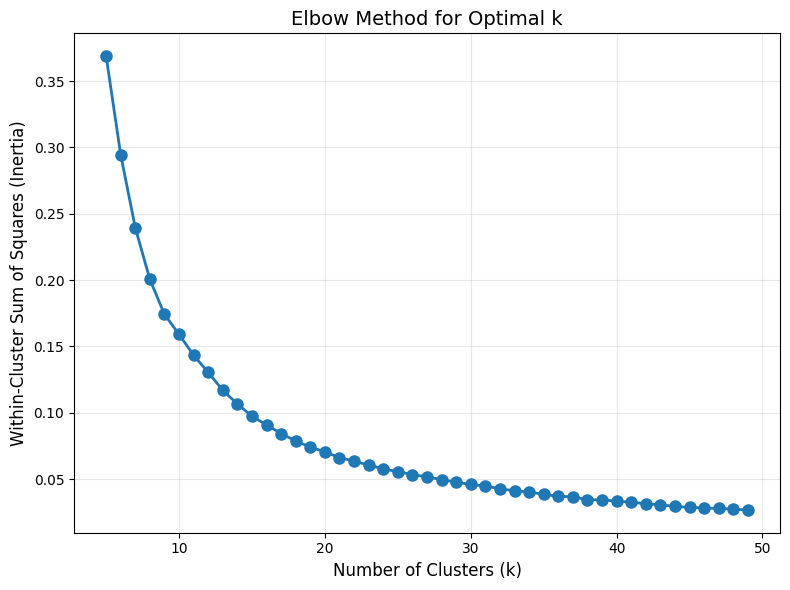

In [57]:
# Different k values
k_values = np.arange(5,50,1)

# ELBOW METHOD: Calculate inertia (within-cluster sum of squares) for each k
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=42,init='k-means++',n_init=10)
    kmeans.fit(stations[['lat', 'lon']])
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Based on the elbow method results, we can argue that **a clustering of 20-30 clusters gives us the best results**

### 2.2.2 Silhouette score

 Unlike the elbow method (which only looks at compactness), the silhouette score directly assesses whether clusters are well-separated, making it especially valuable when we need clusters to be distinct and interpretable. By computing the average silhouette score for different k values, we can identify which k provides the best balance between tight, cohesive clusters and good separation between them. Higher average scores suggest better-defined clusters.

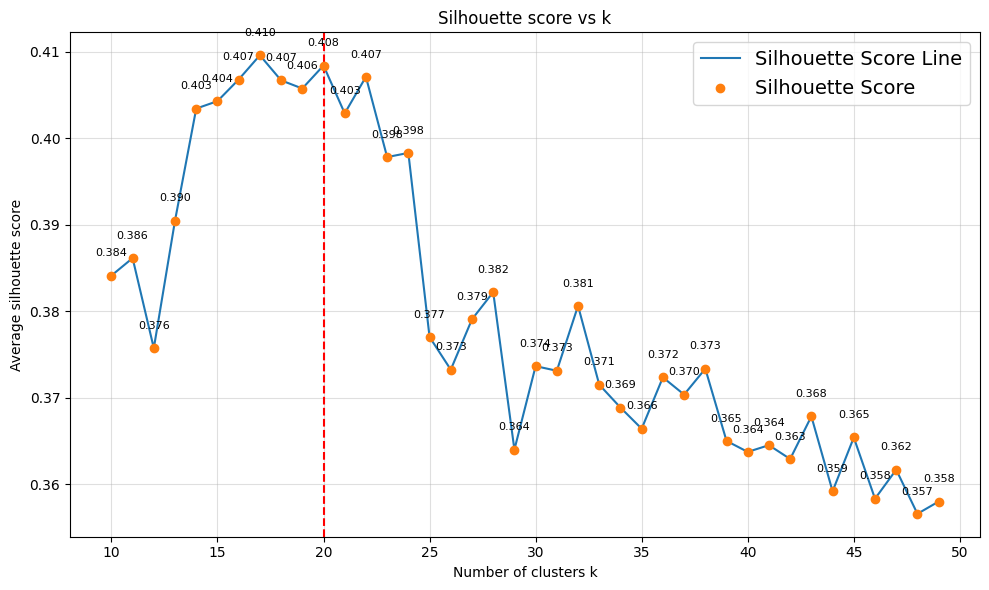

In [60]:
# overall silhouette score
k_values = np.arange(10,50,1)
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=42,init='k-means++',n_init=10)
    clusters = kmeans.fit_predict(stations[['lat', 'lon']])
    score = silhouette_score(stations[['lat', 'lon']], clusters, metric='euclidean')
    sil_scores.append(score)

plt.figure(figsize=(10,6))

#line in one color, markers in another
plt.plot(k_values, sil_scores, color='tab:blue',label='Silhouette Score Line')             # line
plt.scatter(k_values, sil_scores, color='tab:orange', zorder=3, label='Silhouette Score')  # points
plt.axvline(x=20, color='red', linestyle='--', linewidth=1.5)  # vertical line at k=20

# add value labels above each point
for k, s in zip(k_values, sil_scores):
    plt.text(k, s + 0.002, f"{s:.3f}", ha='center', va='bottom', fontsize=8)

plt.xlabel("Number of clusters k")
plt.ylabel("Average silhouette score")
plt.title("Silhouette score vs k")
plt.legend(fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### Silhouette Score Intepretation

The Silhouette Score curve  shows that best values lie within the range of 14 to 22 clusters. Hoever, clustering implementations with less than 20 clusters produced are excluded from our analysis. Therefore, any k value between **20 and 22** provides a high-quality clustering solution. 

## 2.2.3 Visual Representation for the k-values with high silhouette score

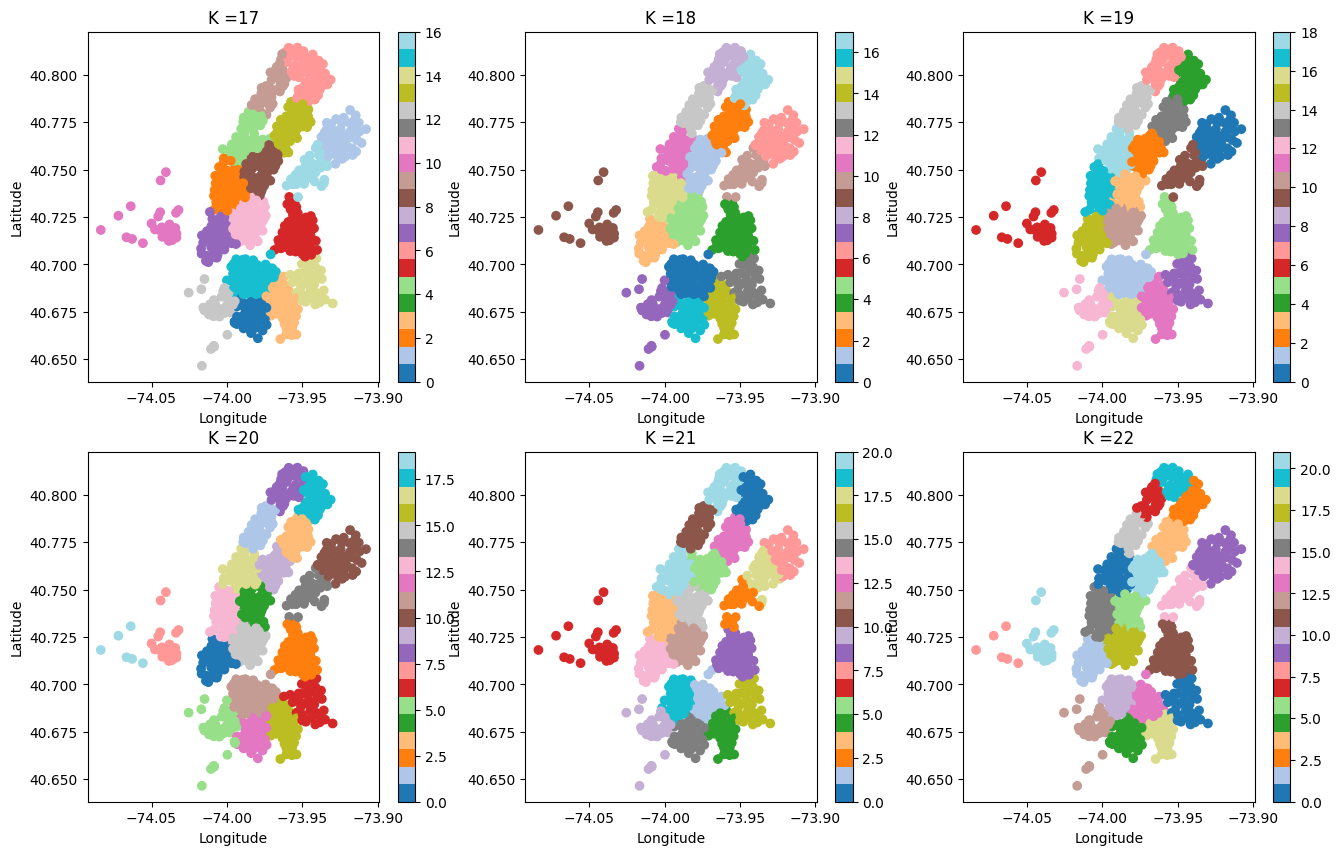

In [65]:
k_values = [17,18,19,20,21,22]

#Plot the clustering results for different k values for k-means clustering
fig,axes = plt.subplots(2,3,figsize=(16,10))
axes = axes.ravel()

for i,k in enumerate(k_values):
    #Fit k-means
    kmeans = KMeans(n_clusters=k,random_state=42,init='k-means++',n_init=10)
    clusters = kmeans.fit_predict(stations[['lat', 'lon']])

    # Add cluster assignment as a new column for each k
    stations[f'cluster_{k}'] = clusters

    scatter = axes[i].scatter(stations['lon'],stations['lat'],c=clusters,cmap='tab20')
    axes[i].set_title(f'K ={k}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(scatter,ax=axes[i])

plt.show()

Based on the metrics and visualisation, we conlclude that the best value to use for the k-means clustering is **k=20 with silhouette score = 0.408**

We add two new columns in our dataframe. These columns show in what cluster do the start and end station belong to. We will need this information for Task II of the prediction challenge.

In [68]:
# Create a dictionary for fast lookup: station_id -> cluster_20
cluster_map = stations.set_index('station_id')['cluster_20']

# Add new columns to dataframe with start and end stations' cluster index
data['start_cluster_20'] = data['start_station_id'].map(cluster_map)
data['end_cluster_20'] = data['end_station_id'].map(cluster_map).astype("Int32")

print(data[['start_cluster_20','end_cluster_20']])

          start_cluster_20  end_cluster_20
0                       17               4
1                       17              17
2                       17              17
3                       17              17
4                       17               1
...                    ...             ...
17480678                13              17
17480679                 8               9
17480680                 0               0
17480681                 8               9
17480682                13               4

[17480683 rows x 2 columns]


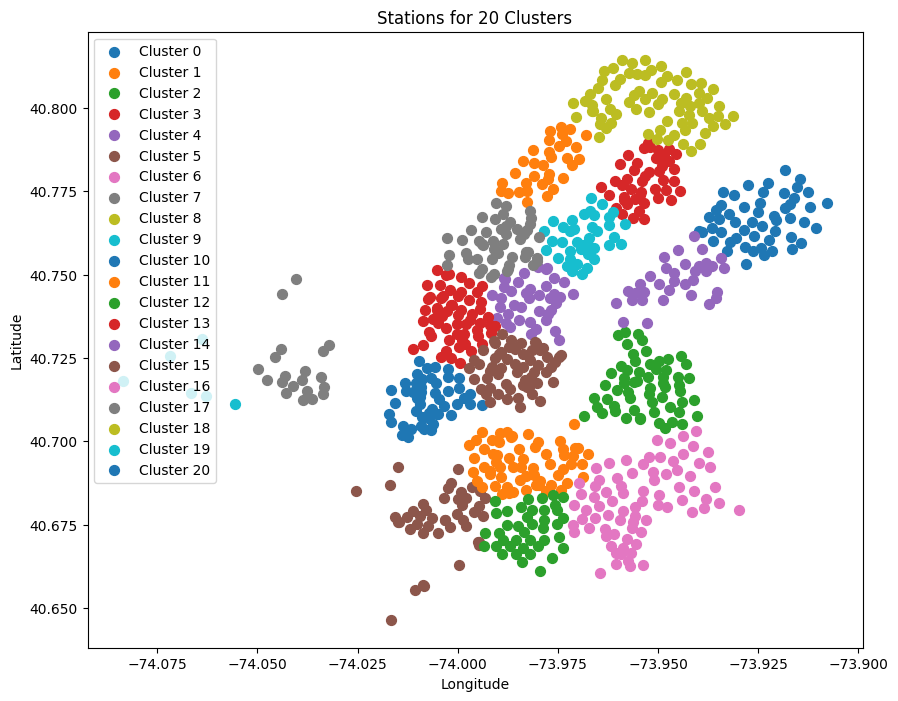

In [71]:
# Clusters to visualize
target_clusters = np.arange(0,21)

# Filter for target clusters
data_plot = stations[stations['cluster_20'].isin(target_clusters)]

# Plot the stations
plt.figure(figsize=(10, 8))
for cluster in target_clusters:
    cluster_data = data_plot[data_plot['cluster_20'] == cluster]
    plt.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}', s=50)

plt.title('Stations for 20 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

## 2.3 DBSCAN

In [72]:
station_test = stations.copy()

In [90]:
#MAIN FUNCTION FOR DBSCAN
# df: columns ['station_id','latitude','longitude']
coords_deg = station_test[['lat','lon']].to_numpy()
coords_rad = np.radians(coords_deg)

#neighborhood in meters!!!
eps_m = 385
eps_rad = eps_m / 6371000.0

clu = DBSCAN(eps=eps_rad, min_samples=5, metric='haversine', algorithm='ball_tree').fit(coords_rad)

station_test['cluster'] = clu.labels_

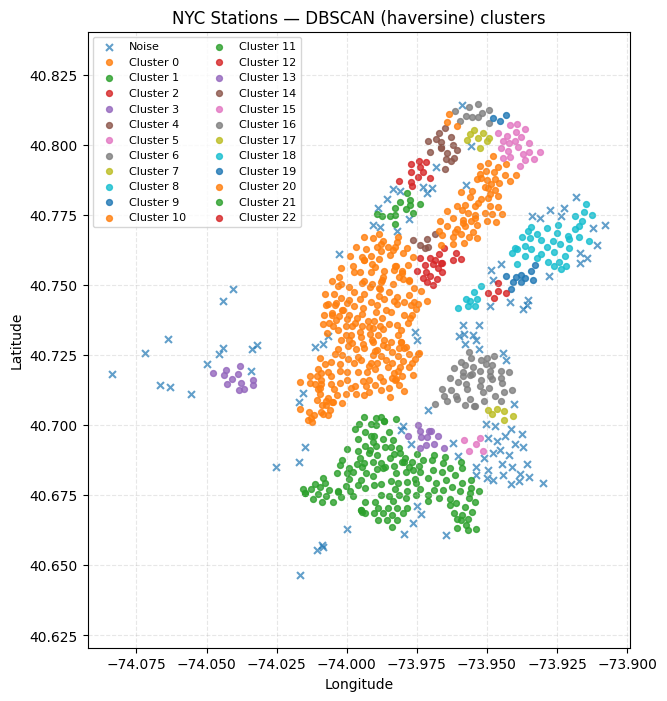

In [91]:
# PLOTING CLUSTERS
labels = station_test['cluster'].to_numpy()
unique_labels = np.unique(labels)

plt.figure(figsize=(7, 8))

for lab in unique_labels:
    mask = labels == lab
    if lab == -1:
        # noise
        plt.scatter(
            station_test.loc[mask, 'lon'], station_test.loc[mask, 'lat'],
            marker='x', s=25, alpha=0.7, label='Noise'
        )
    else:
        plt.scatter(
            station_test.loc[mask, 'lon'], station_test.loc[mask, 'lat'],
            s=18, alpha=0.8, label=f'Cluster {lab}'
        )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Stations — DBSCAN (haversine) clusters')
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.show()

In [92]:
# SEE NUMBER OF NOISE POINTS
n_clusters = (station_test['cluster'] >= 0).sum() and station_test['cluster'][station_test['cluster']>=0].nunique()
n_noise = (station_test['cluster'] == -1).sum()
print("Clusters:", n_clusters, " Noise points:", n_noise)

# Cluster sizes
print(station_test[station_test['cluster']>=0]['cluster'].value_counts().sort_index())


Clusters: 23  Noise points: 115
cluster
0     247
1     146
2      21
3      12
4       6
5       5
6      47
7       6
8       8
9      10
10     63
11     13
12     11
13     12
14     16
15     22
16     10
17      8
18     40
19      3
20      3
21     14
22      5
Name: count, dtype: int64


In [93]:
from sklearn.neighbors import NearestNeighbors

coords_rad = np.radians(station_test[['lat','lon']].to_numpy())
k = 5
nn = NearestNeighbors(n_neighbors=k, metric='haversine', algorithm='ball_tree').fit(coords_rad)
dists, _ = nn.kneighbors(coords_rad)
kth_m = np.sort(dists[:, -1] * 6_371_000)

print("k-distance percentiles [m]:", np.percentile(kth_m, [25,50,60,70,80,90]))
eps_m = float(np.percentile(kth_m, 60))
eps_rad = eps_m / 6_371_000


k-distance percentiles [m]: [321.19481975 361.83454384 385.78012621 412.95175072 450.83369398
 513.19287529]


NEXT ARE METRICS AND GRID SEARCH FOR FINDING BEST COMBINATION OF PARAMETERS

In [77]:
from sklearn.metrics import silhouette_score

coords_rad = np.radians(station_test[['lat','lon']].to_numpy())
labels = station_test['cluster'].to_numpy()
mask = labels != -1
sil = silhouette_score(coords_rad[mask], labels[mask], metric='haversine')
print("Silhouette (haversine):", sil)


Silhouette (haversine): 0.15189385302326552


In [78]:
R = 6_371_000.0
X_rad = np.radians(station_test[['lat','lon']].to_numpy())

def run_dbscan(eps_m, min_samples):
    labels = DBSCAN(eps=eps_m/R, min_samples=min_samples, metric='haversine',
                    algorithm='ball_tree').fit(X_rad).labels_
    return labels


k = 5
nn = NearestNeighbors(n_neighbors=k, metric='haversine').fit(X_rad)
dists, _ = nn.kneighbors(X_rad)
kth_m = np.sort(dists[:, -1] * R)
print("k-dist percentiles [m]:", np.percentile(kth_m, [25,50,60,70,80]))


candidates = []
for eps_m in range(260, 1000, 20):
    for ms in [3,4,5,6,7,8,9,10,12,14]:
        lab = run_dbscan(eps_m, ms)
        n_noise = np.sum(lab == -1)
        n_clust = len(set(lab) - {-1})
        noise_frac = n_noise / len(lab)
        if n_clust >= 20 and noise_frac <= 0.35:
            mask = lab != -1
            sil = silhouette_score(X_rad[mask], lab[mask], metric='haversine') if n_clust>1 else -1
            candidates.append((eps_m, ms, n_clust, noise_frac, sil))


candidates = sorted(candidates, key=lambda x: (-x[4], x[3], -x[2]))
print("Top candidates (eps_m, min_samples, clusters, noise_frac, silhouette):")
for row in candidates[:]:
    print(row)


if candidates:
    eps_m, ms, *_ = candidates[0]
    station_test['cluster'] = run_dbscan(eps_m, ms)
    print(f"Chosen: eps={eps_m} m, min_samples={ms}")


k-dist percentiles [m]: [321.19481975 361.83454384 385.78012621 412.95175072 450.83369398]
Top candidates (eps_m, min_samples, clusters, noise_frac, silhouette):
(300, 3, 62, np.float64(0.22301304863582444), 0.25124860433121715)
(420, 7, 25, np.float64(0.2775800711743772), 0.247170722151178)
(340, 5, 32, np.float64(0.3250296559905101), 0.23030157380466332)
(280, 3, 70, np.float64(0.33214709371293), 0.22239560548955858)
(320, 4, 39, np.float64(0.31316725978647686), 0.2135759508643415)
(460, 8, 23, np.float64(0.2669039145907473), 0.19810299902583178)
(480, 9, 21, np.float64(0.3036773428232503), 0.1849485753278359)
(400, 6, 26, np.float64(0.21708185053380782), 0.16344984661795398)
(380, 6, 28, np.float64(0.31791221826809013), 0.1485526392063545)
(360, 5, 29, np.float64(0.22419928825622776), 0.13878798365005138)
(380, 5, 26, np.float64(0.1506524317912218), 0.09826565241433308)
(340, 4, 27, np.float64(0.17437722419928825), 0.05277238715350218)
(320, 3, 47, np.float64(0.1423487544483986), 0.

In [79]:
def grid_search_dbscan(coords_rad, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_labels = None

    for eps_m in eps_values:
        for min_samples in min_samples_values:

            eps_rad = eps_m / 6371000.0
            db = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine')
            labels = db.fit_predict(coords_rad)


            valid_labels = labels[labels != -1]


            if len(np.unique(valid_labels)) > 1:
                score = silhouette_score(coords_rad[labels != -1], valid_labels, metric='haversine')
                if score > best_score:
                    best_score = score
                    best_params = (eps_m, min_samples)
                    best_labels = labels

    return best_score, best_params, best_labels


eps_values = np.linspace(200, 600, 20)
min_samples_values = range(5, 11)


best_score, best_params, best_labels = grid_search_dbscan(coords_rad, eps_values, min_samples_values)
print(f"Best Silhouette score: {best_score}")
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")


station_test['cluster'] = best_labels

Best Silhouette score: 0.9569118816327751
Best parameters: eps=221.05263157894737, min_samples=5


## 3. Models Comparison 

We compare the final models we have chosen for each clustering method (Mean-Shift, k-means and DBSCAN) and we compare metrics in order to choose what model's results are we going to use for the following tasks. Apart from the Silhouette Score, that have already calculated for every method, we caluclate some internal metrics, where no true labels are needed. These are:

**Davies–Bouldin Index (DBI)**: Measures average similarity between each cluster and its most similar neighbor; lower is better because it means clusters are compact and far apart.

**Calinski–Harabasz Index (CH)**: Ratio of between-cluster dispersion to within-cluster dispersion; higher is better and often used alongside silhouette to pick the number of clusters.

In [145]:
#mean-shift, bandwidth = 0.369
bandwidth = 0.369
ms = MeanShift(bandwidth=b, bin_seeding=True)
labels1 = ms.fit_predict(coords_scaled)
n_clusters = len(np.unique(labels))
score1_sil = silhouette_score(coords_scaled, labels1)
score1_dbi = davies_bouldin_score(coords_scaled, labels1)
score1_ch  = calinski_harabasz_score(coords_scaled, labels1)

#-means , k=20
kmeans = KMeans(n_clusters=20,random_state=42,init='k-means++',n_init=10)
clusters = kmeans.fit_predict(stations[['lat', 'lon']])
score2_sil = silhouette_score(stations[['lat', 'lon']], clusters, metric='euclidean')
score2_dbi = davies_bouldin_score(stations[['lat', 'lon']], clusters)
score2_ch  = calinski_harabasz_score(stations[['lat', 'lon']], clusters)


#DBSCAN, min_samples = 5 and eps = 385 m 
clu = DBSCAN(eps=eps_rad, min_samples=5, metric='haversine', algorithm='ball_tree').fit(coords_rad)
labels3 = clu.labels_
score3_sil = silhouette_score(coords_rad, labels3)
score3_dbi = davies_bouldin_score(coords_rad, labels3)
score3_ch  = calinski_harabasz_score(coords_rad, labels3)


headers = ["Metric", "Mean-Shift", "K-means", "DBSCAN"]
rows = [
    ["Silhouette", f"{score1_sil:.4f}", f"{score2_sil:.4f}", f"{score3_sil:.4f}"],
    ["DBI",        f"{score1_dbi:.4f}", f"{score2_dbi:.4f}", f"{score3_dbi:.4f}"],
    ["CH",         f"{score1_ch:.1f}",  f"{score2_ch:.1f}",  f"{score3_ch:.1f}"],
]

# compute max width of each column
widths = [max(len(str(x)) for x in col) for col in zip(headers, *rows)]

def fmt_row(values):
    return "| " + " | ".join(f"{v:<{w}}" for v, w in zip(values, widths)) + " |"

# print table
print(fmt_row(headers))
print(fmt_row(["-"*w for w in widths]))
for r in rows:
    print(fmt_row(r))

| Metric     | Mean-Shift | K-means | DBSCAN |
| ---------- | ---------- | ------- | ------ |
| Silhouette | 0.3795     | 0.4084  | 0.0240 |
| DBI        | 0.7010     | 0.7494  | 1.4381 |
| CH         | 862.6      | 1153.7  | 95.7   |


### 3.1 Metrics Comparison Outcome

1. Based on the **silhouette score**, the method that perfoms best is **k-means** with **0.4084**.
2. For Davis-Bouldin Index (DBI), the lower the better. Therefore, **Mean-Shift** win this comparison with a **DBI score = 0.7010**, with **k-means** coming close.
3. Regarding the Calinski–Harabasz (CH), the higher is better. **K-means**, once again, has the best outcome with **CH score = 1153.7**

Since **k-means** dominates two metrics and comes very close in the third one, we conclude that for the purpose of this Assignment we are going to use the **k=20 clustering results**


## 4. Real map visualisation

Use folium to visualise clustering of the dataset. This can help us choose the clusters we want to make predictions for.

In [149]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a map centered on the data
map_center = [data_plot['lat'].mean(), data_plot['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Generate a color for each cluster using a colormap
colormap = cm.get_cmap('tab20', len(target_clusters))
colors = [mcolors.to_hex(colormap(i)) for i in range(len(target_clusters))]

# Add markers for each cluster
for idx, cluster in enumerate(target_clusters):
    cluster_data = data_plot[data_plot['cluster_20'] == cluster]
    color = colors[idx]
    
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            color=color,
            radius=6,
            fill=True,
            fill_color=color,
            popup=f"Cluster: {cluster}"
        ).add_to(m)

m.save('clusters_map.html')

C:\Users\billy\AppData\Local\Temp\ipykernel_4012\1049632091.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(target_clusters))
